In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


Starting training with optimized parameters...
Initial learning rate: 0.01
Batch size: 8
Maximum epochs: 500
Early stopping patience: 50
Epoch 20/500, Train Loss: 0.002924, Val Loss: 0.003474, LR: 0.010000
Epoch 40/500, Train Loss: 0.002834, Val Loss: 0.003187, LR: 0.010000
Epoch 60/500, Train Loss: 0.002756, Val Loss: 0.003213, LR: 0.010000
Epoch 80/500, Train Loss: 0.002734, Val Loss: 0.002937, LR: 0.010000
Epoch 100/500, Train Loss: 0.002682, Val Loss: 0.003193, LR: 0.010000
Epoch 120/500, Train Loss: 0.002655, Val Loss: 0.002897, LR: 0.010000
Epoch 140/500, Train Loss: 0.002643, Val Loss: 0.002854, LR: 0.010000
Epoch 160/500, Train Loss: 0.002595, Val Loss: 0.002787, LR: 0.010000
Convergence detected at epoch 162
Training completed!


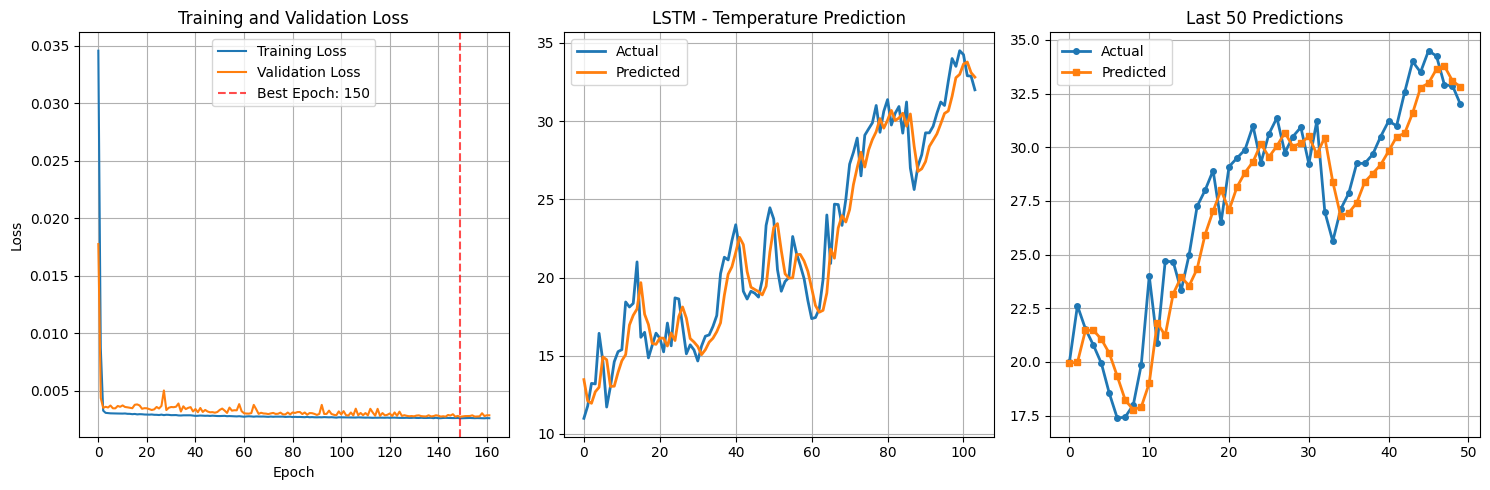


Performance Metrics:
Total Epochs Trained: 162
Best Epoch: 150
Final Training Loss: 0.002603
Final Validation Loss: 0.002854
Mean Squared Error (MSE): 3.0548
Root Mean Squared Error (RMSE): 1.7478
Mean Absolute Error (MAE): 1.4209

Loss Trend Analysis (last 50 epochs):
Training loss slope: -0.00000092
Validation loss slope: -0.00001133
→ Losses are still decreasing - consider training longer


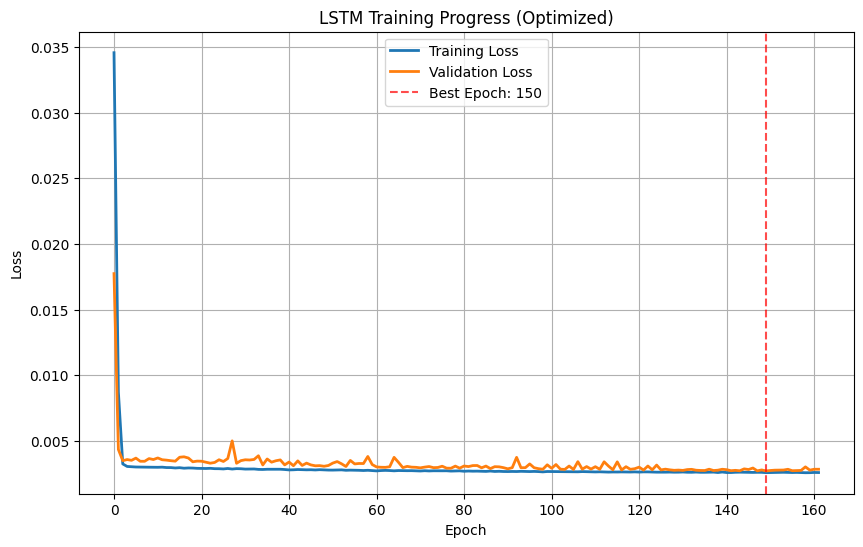

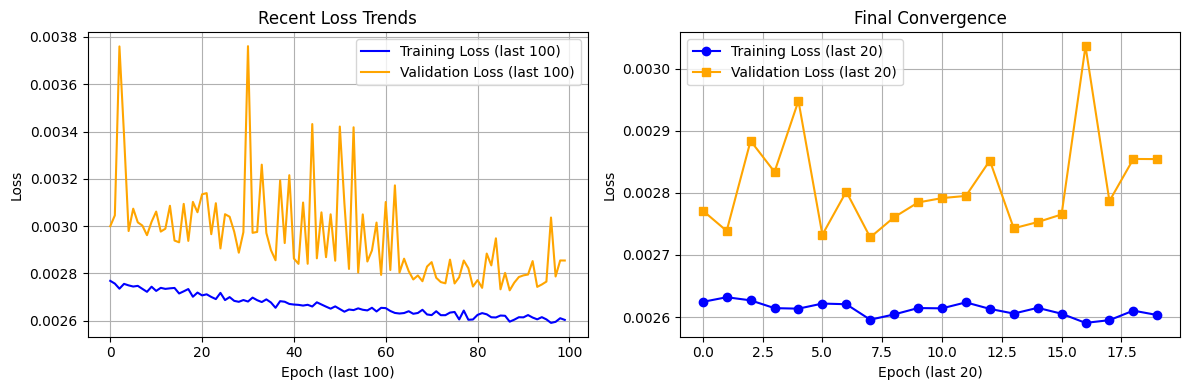

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_data = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
test_data = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv")

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data = train_data.sort_values('date')
test_data = test_data.sort_values('date')

train_values = train_data['meantemp'].values.reshape(-1, 1)
test_values = test_data['meantemp'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_values)
scaled_test = scaler.transform(test_values)

def create_dataset(dataset, time_steps=10):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 10
X_train, y_train = create_dataset(scaled_train, time_steps)
X_test, y_test = create_dataset(scaled_test, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - x ** 2

class LSTM:
    def __init__(self, input_size, hidden_size, output_size, lr=0.001):
        self.hidden_size = hidden_size
        self.lr = lr
        
        limit = np.sqrt(1 / hidden_size)
        self.Wf = np.random.uniform(-limit, limit, (hidden_size, input_size + hidden_size))
        self.Wi = np.random.uniform(-limit, limit, (hidden_size, input_size + hidden_size))
        self.Wo = np.random.uniform(-limit, limit, (hidden_size, input_size + hidden_size))
        self.Wc = np.random.uniform(-limit, limit, (hidden_size, input_size + hidden_size))
        self.Wy = np.random.uniform(-limit, limit, (output_size, hidden_size))
        
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, x_seq):
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))
        self.cache = []
        
        for x in x_seq:
            x = x.reshape(-1, 1)
            concat = np.vstack((h_prev, x))
            f = sigmoid(self.Wf @ concat + self.bf)
            i = sigmoid(self.Wi @ concat + self.bi)
            o = sigmoid(self.Wo @ concat + self.bo)
            c_hat = tanh(self.Wc @ concat + self.bc)
            c = f * c_prev + i * c_hat
            h = o * tanh(c)
            self.cache.append((f, i, o, c_hat, c, h, concat))
            h_prev, c_prev = h, c
            
        y = self.Wy @ h + self.by
        return y, h, c

    def backward(self, x_seq, dy):
        dWy = dy @ self.cache[-1][5].T
        dby = dy
        
        dh_next = self.Wy.T @ dy
        dc_next = np.zeros_like(dh_next)
        
        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWo = np.zeros_like(self.Wo)
        dWc = np.zeros_like(self.Wc)
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbo = np.zeros_like(self.bo)
        dbc = np.zeros_like(self.bc)

        for t in reversed(range(len(x_seq))):
            f, i, o, c_hat, c, h, concat = self.cache[t]
            dh = dh_next
            dc = dc_next + dh * o * dtanh(tanh(c))
            do = dh * tanh(c) * dsigmoid(o)
            di = dc * c_hat * dsigmoid(i)
            df = dc * (self.cache[t-1][4] if t > 0 else np.zeros_like(c)) * dsigmoid(f)
            dc_hat = dc * i * dtanh(c_hat)
            
            dWf += df @ concat.T
            dWi += di @ concat.T
            dWo += do @ concat.T
            dWc += dc_hat @ concat.T
            dbf += df
            dbi += di
            dbo += do
            dbc += dc_hat
            
            dconcat = (self.Wf.T @ df +
                       self.Wi.T @ di +
                       self.Wo.T @ do +
                       self.Wc.T @ dc_hat)
            dh_next = dconcat[:self.hidden_size, :]
            dc_next = f * dc
            
        clip_value = 5.0
        for dparam in [dWf, dWi, dWo, dWc, dWy, dbf, dbi, dbo, dbc, dby]:
            np.clip(dparam, -clip_value, clip_value, out=dparam)
            
        for param, dparam in zip(
            [self.Wf, self.Wi, self.Wo, self.Wc, self.Wy, self.bf, self.bi, self.bo, self.bc, self.by],
            [dWf, dWi, dWo, dWc, dWy, dbf, dbi, dbo, dbc, dby]):
            param -= self.lr * dparam

np.random.seed(42)
model = LSTM(input_size=1, hidden_size=32, output_size=1, lr=0.01)
epochs = 500
best_val_loss = float('inf')
patience = 50
patience_counter = 0
min_lr = 0.00001
batch_size = 8

train_losses = []
val_losses = []

print("Starting training with optimized parameters...")
print(f"Initial learning rate: {model.lr}")
print(f"Batch size: {batch_size}")
print(f"Maximum epochs: {epochs}")
print(f"Early stopping patience: {patience}")

for epoch in range(epochs):
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    train_loss = 0
    for i in range(0, len(X_train_shuffled), batch_size):
        batch_end = min(i + batch_size, len(X_train_shuffled))
        batch_loss = 0
        
        for j in range(i, batch_end):
            y_pred, h, c = model.forward(X_train_shuffled[j])
            loss = (y_pred - y_train_shuffled[j]) ** 2
            batch_loss += loss[0, 0]
            dy = 2 * (y_pred - y_train_shuffled[j])
            model.backward(X_train_shuffled[j], dy)
        
        train_loss += batch_loss
    
    avg_train_loss = train_loss / len(X_train)
    train_losses.append(avg_train_loss)
    
    val_loss = 0
    for i in range(len(X_test)):
        y_pred, _, _ = model.forward(X_test[i])
        loss = (y_pred - y_test[i]) ** 2
        val_loss += loss[0, 0]
    
    avg_val_loss = val_loss / len(X_test)
    val_losses.append(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience // 3:
            old_lr = model.lr
            model.lr *= 0.8
            model.lr = max(model.lr, min_lr)
            if old_lr != model.lr:
                print(f"Reducing learning rate to: {model.lr:.6f}")
    
    if epoch > 100 and len(val_losses) > 1:
        loss_change = abs(avg_val_loss - val_losses[-2])
        if loss_change < 1e-6:
            print(f"Convergence detected at epoch {epoch+1}")
            break
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {model.lr:.6f}")

print("Training completed!")

predictions = []
for i in range(len(X_test)):
    y_pred, _, _ = model.forward(X_test[i])
    predictions.append(y_pred.flatten()[0])

predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

best_epoch = np.argmin(val_losses)
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch+1}')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predictions, label="Predicted", linewidth=2)
plt.legend()
plt.title("LSTM - Temperature Prediction")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(actual[-50:], label="Actual", linewidth=2, marker='o', markersize=4)
plt.plot(predictions[-50:], label="Predicted", linewidth=2, marker='s', markersize=4)
plt.legend()
plt.title("Last 50 Predictions")
plt.grid(True)

plt.tight_layout()
plt.savefig("/kaggle/working/lstm_daily_climate_result.png", dpi=300, bbox_inches="tight")
plt.show()

mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mse)

print(f"\nPerformance Metrics:")
print(f"Total Epochs Trained: {len(train_losses)}")
print(f"Best Epoch: {best_epoch+1}")
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

if len(train_losses) > 100:
    recent_train = train_losses[-50:]
    recent_val = val_losses[-50:]
    
    train_slope = (recent_train[-1] - recent_train[0]) / len(recent_train)
    val_slope = (recent_val[-1] - recent_val[0]) / len(recent_val)
    
    print(f"\nLoss Trend Analysis (last 50 epochs):")
    print(f"Training loss slope: {train_slope:.8f}")
    print(f"Validation loss slope: {val_slope:.8f}")
    
    if abs(train_slope) < 1e-6 and abs(val_slope) < 1e-6:
        print("✓ Model has converged - losses are stable")
    elif train_slope < -1e-6 or val_slope < -1e-6:
        print("→ Losses are still decreasing - consider training longer")
    else:
        print("⚠ Losses might be increasing - possible overfitting")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Progress (Optimized)')
plt.legend()
plt.grid(True)
plt.savefig("/kaggle/working/lstm_training_loss_optimized.png", dpi=300, bbox_inches="tight")
plt.show()

if len(train_losses) > 100:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses[-100:], label='Training Loss (last 100)', color='blue')
    plt.plot(val_losses[-100:], label='Validation Loss (last 100)', color='orange')
    plt.xlabel('Epoch (last 100)')
    plt.ylabel('Loss')
    plt.title('Recent Loss Trends')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses[-20:], label='Training Loss (last 20)', color='blue', marker='o')
    plt.plot(val_losses[-20:], label='Validation Loss (last 20)', color='orange', marker='s')
    plt.xlabel('Epoch (last 20)')
    plt.ylabel('Loss')
    plt.title('Final Convergence')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("/kaggle/working/lstm_convergence_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()